# Predicting Bike Rental Demand Using Machine Learning

#### Understanding the Business Scenario and Problem

The city’s bike rental company wants to optimize its operations and improve customer satisfaction by ensuring that bikes are available when and where customers need them. They have been collecting historical data on bike usage, but they are unsure how to turn this data into actionable insights. They reach out to you, a data analytics professional, to help analyze the data and provide evidence-based recommendations.

##### The central business question is: 
What factors influence bike rental demand, and how can future demand be predicted?

The goals of this project are to analyze the bike rental data and build models that can forecast rental demand based on factors such as weather, time, and season.

In [1]:
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import RandomizedSearchCV


In [2]:
# Loading dataset into a dataframe
df = pd.read_csv("vlib.csv")

# Displaying first few rows of the dataframe
df.head(10)

datetime  season  holiday  workingday  weather   temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1   9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1   9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1   9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1   9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1   9.84  14.395   
5  2011-01-01 05:00:00       1        0           0        2   9.84  12.880   
6  2011-01-01 06:00:00       1        0           0        1   9.02  13.635   
7  2011-01-01 07:00:00       1        0           0        1   8.20  12.880   
8  2011-01-01 08:00:00       1        0           0        1   9.84  14.395   
9  2011-01-01 09:00:00       1        0           0        1  13.12  17.425   

   humidity  windspeed  casual  registered  count  
0        81     0.0000       3          13     16  
1        80     0.0000       8          32     40  
2        80     0.0000       5          27     32  
3        75     0.0000       3          10     13  
4        75     0.0000       0           1      1  
5        75     6.0032       0           1      1  
6        80     0.0000       2           0      2  
7        86     0.0000       1           2      3  
8        75     0.0000       1           7      8  
9        76     0.0000       8           6     14

In [3]:
# Displaying the shape of the dataset
df.shape

(10886, 12)

In [4]:
# Checking for missing values
df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [5]:
# Checking for duplicates
df.duplicated().sum()

0

In [6]:
# Gathering descriptive statistics about the data
df.describe()

season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.960477    151.039033   
min        0.760000      0.000000      0.000000      0.000000      0.000000   
25%       16.665000     47.000000      7.001500      4.000000     36.000000   
50%       24.240000     62.000000     12.998000     17.000000    118.000000   
75%       31.060000     77.000000     16.997900     49.000000    222.000000   
max       45.455000    100.000000     56.996900    367.000000    886.000000   

              count  
count  10886.000000  
mean     191.574132  
std      181.144454  
min        1.000000  
25%       42.000000  
50%      145.000000  
75%      284.000000  
max      977.000000

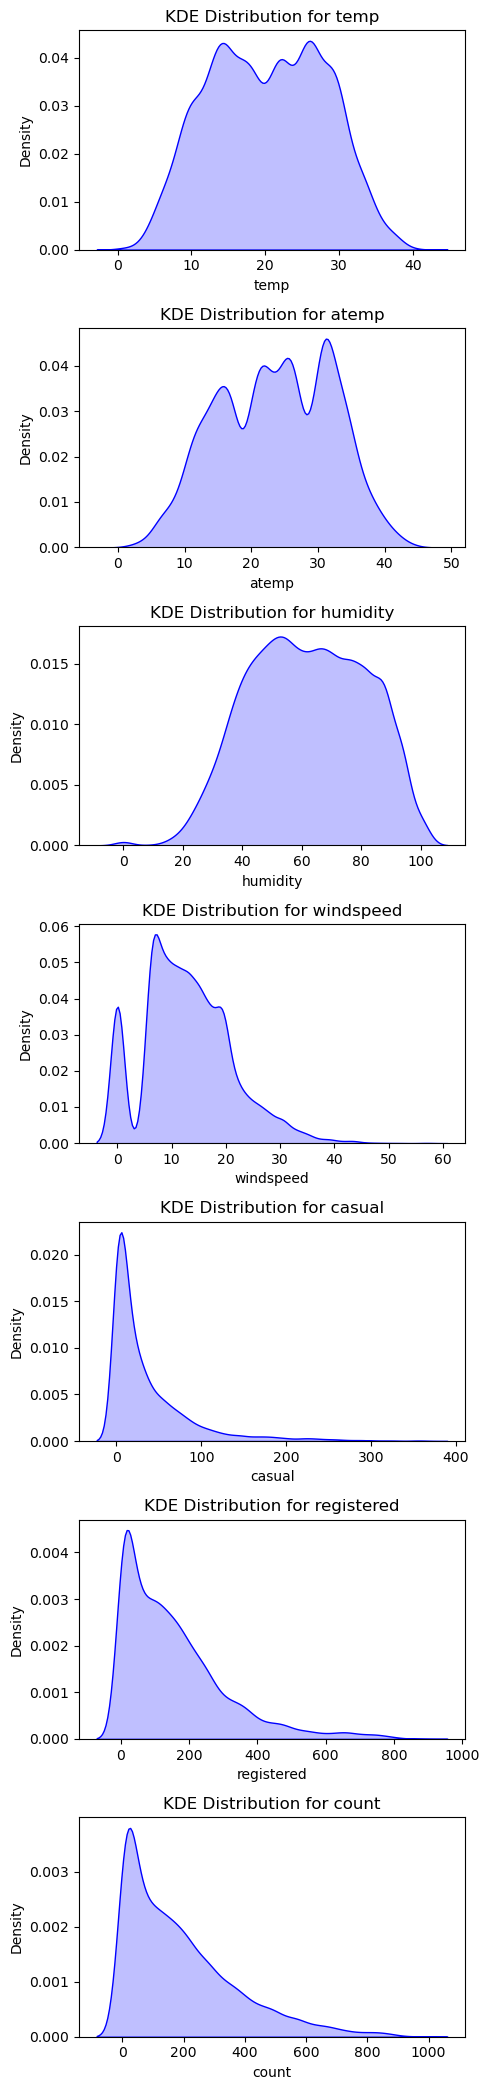

In [7]:
# Dropping specified columns
colns_drop = ["datetime", "season", "holiday", "workingday", "weather"]
df_kde = df.drop(columns=colns_drop, errors="ignore")

numeric_cols = df_kde.select_dtypes(include=np.number).columns

plt.figure(figsize=(5, len(numeric_cols) * 3))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.kdeplot(pd.to_numeric(df_kde[col], errors="coerce").dropna(), fill=True, color="blue")
    plt.title(f"KDE Distribution for {col}")
plt.tight_layout()
plt.show()


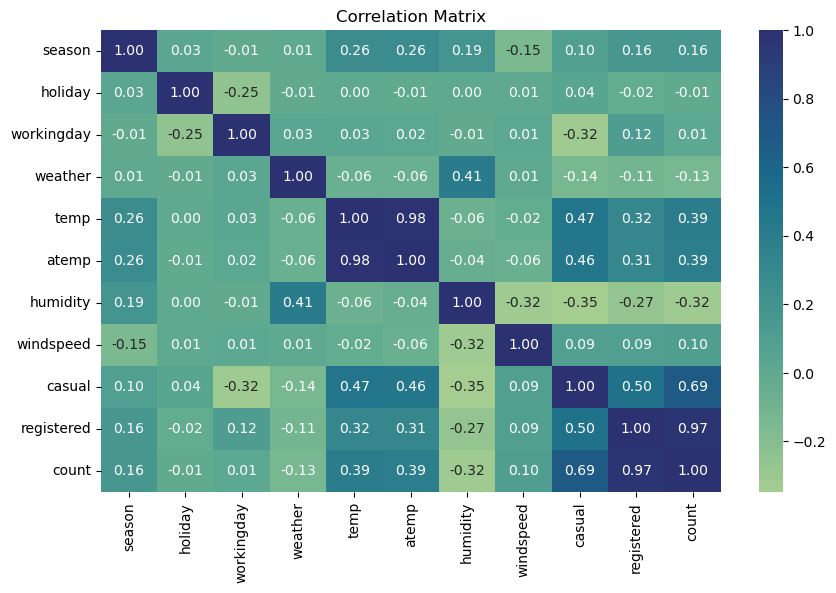

In [8]:
# Correlation Matrix

numeric_df = df.select_dtypes(include=np.number)
corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="crest")
plt.title("Correlation Matrix")
plt.show()

The count variable shows a very strong correlation with registered users (0.97) and a moderate correlation with casual users (0.69), indicating that registered riders contribute the most to total rentals. Temperature and feels-like temperature are almost identical (0.98 correlation), suggesting they provide overlapping information. Both temperature measures have a moderate positive relationship with count (~0.39), meaning warmer weather tends to boost bike usage. Alternatively, humidity has a slight negative correlation with count (-0.32), implying that higher humidity slightly decreases rentals.

In [9]:
# Correlation with rentals
corr = df.corr()['count'].sort_values(ascending=False)
print("Correlation with Rentals:\n", corr)

Correlation with Rentals:
 count         1.000000
registered    0.970948
casual        0.690414
temp          0.394454
atemp         0.389784
season        0.163439
windspeed     0.101369
workingday    0.011594
holiday      -0.005393
weather      -0.128655
humidity     -0.317371
Name: count, dtype: float64


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1564\136842389.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()['count'].sort_values(ascending=False)


In [10]:
# Ensure datetime is parsed
if 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'])
    print('Parsed datetime column to pandas datetime')
else:
    print('No datetime column found')

Parsed datetime column to pandas datetime


In [11]:
# Feature extraction from datetime

df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek

print(df[['datetime','year','month','day','hour','dayofweek']].head(10))


             datetime  year  month  day  hour  dayofweek
0 2011-01-01 00:00:00  2011      1    1     0          5
1 2011-01-01 01:00:00  2011      1    1     1          5
2 2011-01-01 02:00:00  2011      1    1     2          5
3 2011-01-01 03:00:00  2011      1    1     3          5
4 2011-01-01 04:00:00  2011      1    1     4          5
5 2011-01-01 05:00:00  2011      1    1     5          5
6 2011-01-01 06:00:00  2011      1    1     6          5
7 2011-01-01 07:00:00  2011      1    1     7          5
8 2011-01-01 08:00:00  2011      1    1     8          5
9 2011-01-01 09:00:00  2011      1    1     9          5


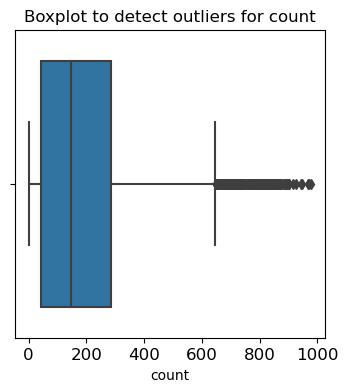

In [12]:
# Determining outliers in count column
plt.figure(figsize=(4,4))
plt.title('Boxplot to detect outliers for count', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df['count'])
plt.show()

There are outliers in the count variables. These are unusually high counts, possibly due to events, weather anomalies, promotions, or errors.

In [13]:
# Determining the number of rows containing outliers 

# Computing the 25th percentile value in `count`
percentile25 = df['count'].quantile(0.25)

# Computing the 75th percentile value in `count`
percentile75 = df['count'].quantile(0.75)

# Computing the interquartile range in `count`
iqr = percentile75 - percentile25

# Defining the upper limit and lower limit for non-outlier values in `count`
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

# Identifying subset of data containing outliers in `count`
outliers = df[(df['count'] > upper_limit) | (df['count'] < lower_limit)]

# Counting how many rows in the data contain outliers in `count`
print("Number of rows in the data containing outliers in `count`:", len(outliers))

Lower limit: -321.0
Upper limit: 647.0
Number of rows in the data containing outliers in `count`: 300


In [14]:
# Selecting rows without outliers in `count` and saving result in dataframe in a new variable
df1 = df[(df['count'] >= lower_limit) & (df['count'] <= upper_limit)]

# Displaying 1st ten rows of the dataframe
df1.head(10)

datetime  season  holiday  workingday  weather   temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1   9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1   9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1   9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1   9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1   9.84  14.395   
5 2011-01-01 05:00:00       1        0           0        2   9.84  12.880   
6 2011-01-01 06:00:00       1        0           0        1   9.02  13.635   
7 2011-01-01 07:00:00       1        0           0        1   8.20  12.880   
8 2011-01-01 08:00:00       1        0           0        1   9.84  14.395   
9 2011-01-01 09:00:00       1        0           0        1  13.12  17.425   

   humidity  windspeed  casual  registered  count  year  month  day  hour  \
0        81     0.0000       3          13     16  2011      1    1     0   
1        80     0.0000       8          32     40  2011      1    1     1   
2        80     0.0000       5          27     32  2011      1    1     2   
3        75     0.0000       3          10     13  2011      1    1     3   
4        75     0.0000       0           1      1  2011      1    1     4   
5        75     6.0032       0           1      1  2011      1    1     5   
6        80     0.0000       2           0      2  2011      1    1     6   
7        86     0.0000       1           2      3  2011      1    1     7   
8        75     0.0000       1           7      8  2011      1    1     8   
9        76     0.0000       8           6     14  2011      1    1     9   

   dayofweek  
0          5  
1          5  
2          5  
3          5  
4          5  
5          5  
6          5  
7          5  
8          5  
9          5

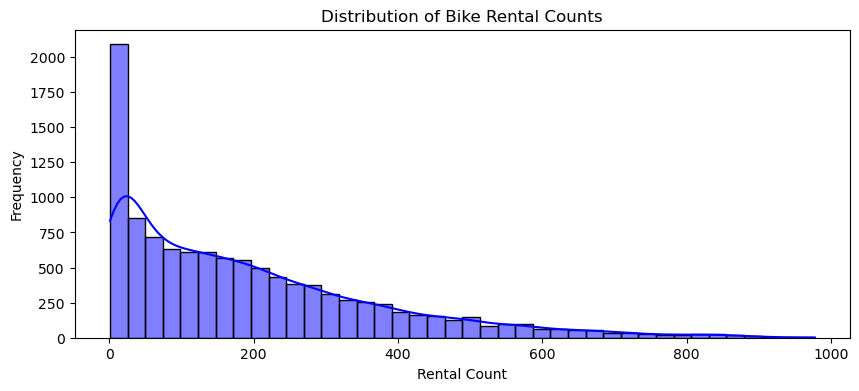

In [15]:
plt.figure(figsize=(10,4))
sns.histplot(df['count'], bins=40, kde=True, color='blue')
plt.title("Distribution of Bike Rental Counts")
plt.xlabel("Rental Count")
plt.ylabel("Frequency")
plt.show()


The data appears to follow a right-skewed distribution, where the majority of rental counts are clustered at the lower end, with a peak around 0-50 rentals, reaching a frequency of approximately 2000. As the rental count increases, the frequency drops sharply, tapering off to near zero around 1000 rentals. This suggests that most rental instances involve a relatively low number of bikes, with fewer instances of high rental counts. 

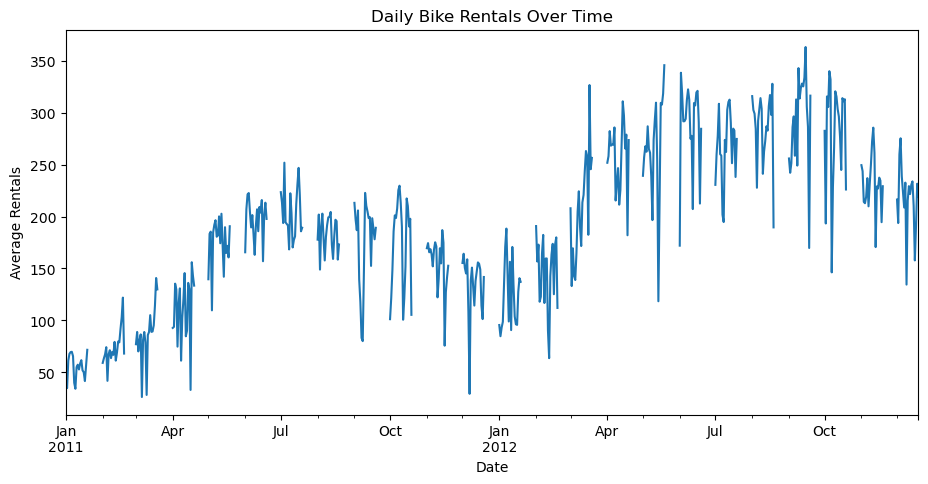

In [16]:
plt.figure(figsize=(11,5))
df.set_index('datetime')['count'].resample('D').mean().plot()
plt.title("Daily Bike Rentals Over Time")
plt.xlabel("Date")
plt.ylabel("Average Rentals")
plt.show()


###### Overall Growth Trend (2011 → 2012)

Rentals generally increase from early 2011 through mid-2012.

The system gained popularity over time — likely due to more users registering, awareness campaigns, or improved infrastructure.


###### Seasonality

Rentals rise during spring and summer months, peaking in July–September, then dip in late fall and winter.

This seasonal cycle repeats in both 2011 and 2012, showing that weather and temperature strongly affect demand.


###### Yearly Comparison

In 2011, average rentals peaked around 200–250 per day.

By 2012, peaks increased to 300–350 per day, indicating strong system growth and higher adoption.


###### Sudden Drops

Sharp downward spikes (sudden drops to near-zero rentals) appear occasionally.

These could be due to extreme weather (storms, snow, rain), system outages, holidays, or data recording issues.


###### Recent Decline

Toward the end of 2012, rentals begin to decline after October.

This aligns with colder weather and shorter daylight hours — people ride less in winter.


###### NB

Bike demand is highest in summer; resources (bike availability, maintenance, promotions) should be concentrated then.

Extreme weather and holidays cause demand dips, so incorporating weather forecasts and event calendars improves predictions.

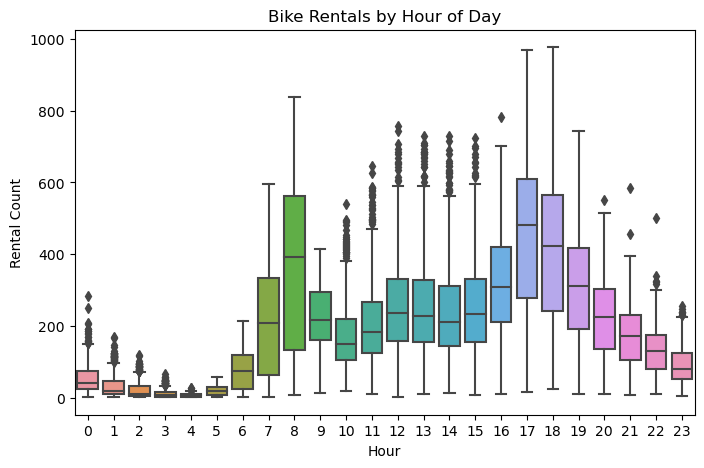

In [17]:
plt.figure(figsize=(8,5))
sns.boxplot(x='hour', y='count', data=df)
plt.title("Bike Rentals by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Rental Count")
plt.show()


###### Morning Peak (7–9 AM)

Rental counts rise sharply between 7–9 AM, with the median much higher than other early hours.

This reflects commuter traffic: people using bikes to get to work or school.

The spread (IQR) is wide, meaning demand fluctuates — some days are moderate, others very high.


###### Midday Steady Demand (10 AM – 3 PM)

Rentals remain stable through the late morning and early afternoon.

Medians are lower than peak hours, but the distribution is consistent, suggesting bikes are used for errands, leisure rides, or flexible schedules.


###### Evening Peak (5–7 PM)

Another strong surge appears between 5–7 PM, matching commute hours after work/school.

Evening demand is typically higher than morning demand (note the higher medians and extreme outliers).

This implies heavy reliance on bikes for evening mobility, perhaps because public transport is crowded, or people prefer cycling home.

###### Late Night (8 PM onwards)

Rentals decline steadily after 8 PM.

By midnight to 4 AM, counts are very low (often close to zero), which makes sense as most people are home.


###### Outliers (Black Dots)

Outliers appear especially in peak commuting hours (7–9 AM, 5–7 PM).

These may represent special events, unusually good weather, or promotions that caused more rentals than usual.


###### NB:

Hour of day is a critical feature; it strongly influences demand. Using cyclical encoding (sin/cos) is justified.

Bike availability should be maximized at 7–9 AM and 5–7 PM, since shortages in these hours can frustrate commuters.

Redistribution of bikes is important — bikes may need to be moved back to residential areas at night for the next morning’s peak.

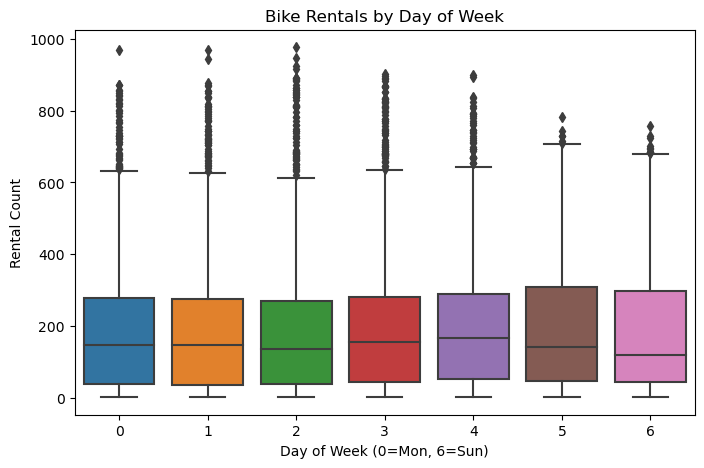

In [18]:
plt.figure(figsize=(8,5))
sns.boxplot(x='dayofweek', y='count', data=df)
plt.title("Bike Rentals by Day of Week")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.ylabel("Rental Count")
plt.show()


This chart displays the distribution of bike rentals by day of the week, using a box plot for each day (0 = Sunday, 1 = Monday, ..., 6 = Saturday). Each box plot shows the median (central line), interquartile range (box), and whiskers (extending to the minimum and maximum within 1.5 times the interquartile range), with outliers marked as diamonds.

Rental counts are highest and most variable on weekends (days 0 and 6), with medians around 200-300 and some outliers reaching up to 1000.
Midweek days (1-4) show lower and more consistent rental counts, with medians around 200-250 and fewer outliers.
Day 5 (Friday) has a median similar to midweek but with a slightly wider spread and more outliers, suggesting increased variability toward the weekend.

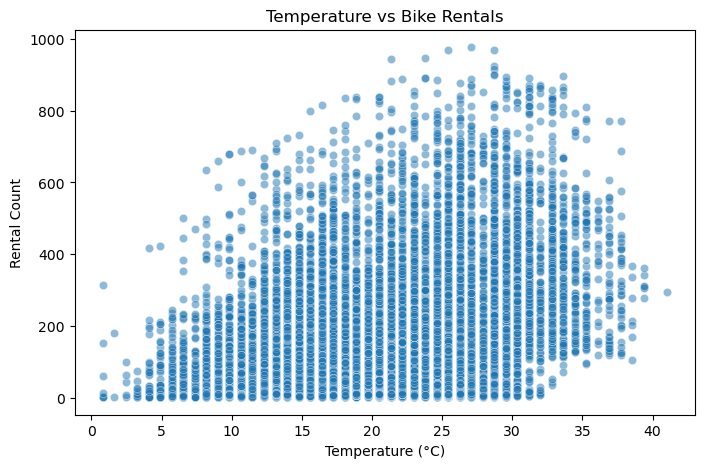

In [19]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='temp', y='count', data=df, alpha=0.5)
plt.title("Temperature vs Bike Rentals")
plt.xlabel("Temperature (°C)")
plt.ylabel("Rental Count")
plt.show()


This chart illustrates the relationship between temperature (in Celsius) and bike rental counts using a scatter plot. The x-axis represents temperature, ranging from 0°C to 40°C, while the y-axis shows the rental count, ranging from 0 to 1000. The data points form a dense, upward-trending cluster, indicating that higher temperatures are generally associated with higher bike rental counts. The densest concentration of rentals occurs between 15°C and 35°C, with counts frequently exceeding 400 and peaking around 800-1000. Below 15°C and above 35°C, rental counts drop significantly, suggesting that extreme temperatures (very cold or very hot) reduce bike usage.

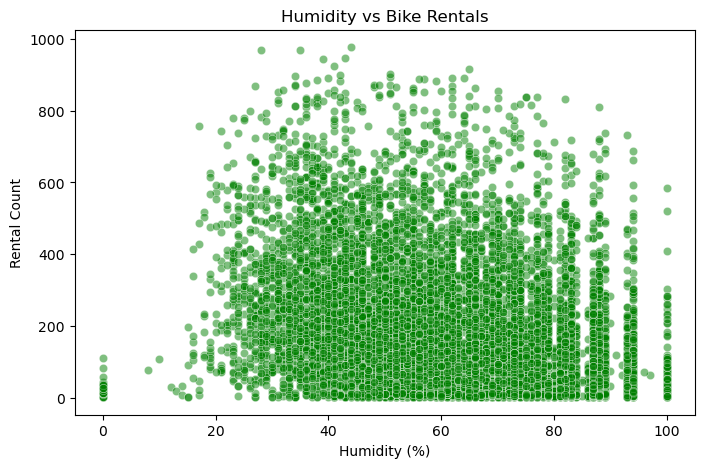

In [20]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='humidity', y='count', data=df, alpha=0.5, color='green')
plt.title("Humidity vs Bike Rentals")
plt.xlabel("Humidity (%)")
plt.ylabel("Rental Count")
plt.show()


This chart shows the relationship between humidity (in percentage) and bike rental counts using a scatter plot. The x-axis represents humidity, ranging from 0% to 100%, while the y-axis shows the rental count, ranging from 0 to 1000. The data points are densely clustered, with the highest concentration of rentals occurring between 20% and 80% humidity, where rental counts frequently range from 200 to 800, with some reaching up to 1000. Outside this range (below 20% or above 80%), rental counts drop significantly, with very few instances exceeding 200. This suggests that moderate humidity levels (20%-80%) are associated with higher bike rental activity, while very low or very high humidity tends to reduce usage.

In [21]:
pivot = df.pivot_table(values='count', index='dayofweek', columns='hour', aggfunc='mean').reset_index()
fig = px.imshow(pivot.iloc[:,1:], 
                labels=dict(x="Hour", y="Day of Week", color="Avg Rentals"),
                x=pivot.columns[1:], 
                y=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"],
                aspect="auto", color_continuous_scale="YlGnBu")
fig.update_layout(title="Interactive Heatmap of Rentals by Hour & Day")
fig.show()


In [22]:
fig = px.line(df, x="datetime", y="count", title="Interactive Time Series of Bike Rentals")
fig.update_xaxes(rangeslider_visible=True)
fig.show()


In [23]:
fig = px.scatter(df, x="temp", y="count", color="season", facet_col="weather",
                 opacity=0.7, title="Rentals by Temperature, Season & Weather")
fig.show()


In [24]:
fig = px.scatter_3d(df, x="hour", y="temp", z="count", color="season",
                    title="3D Rentals by Hour, Temp & Season", opacity=0.7)
fig.show()


In [25]:
# Rentals by season
print(df.groupby('season')['count'].mean().sort_values(ascending=False))

# Rentals by month
print(df.groupby('month')['count'].mean())

# Rentals by hour
print(df.groupby('hour')['count'].mean())



season
3    234.417124
2    215.251372
4    198.988296
1    116.343261
Name: count, dtype: float64
month
1      90.366516
2     110.003330
3     148.169811
4     184.160616
5     219.459430
6     242.031798
7     235.325658
8     234.118421
9     233.805281
10    227.699232
11    193.677278
12    175.614035
Name: count, dtype: float64
hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: count, dtype: float64


In [26]:
# Rentals by weather condition
print(df.groupby('weather')['count'].agg(['mean','median','std']))

# Rentals on holidays vs working days
print(df.groupby('holiday')['count'].mean())
print(df.groupby('workingday')['count'].mean())


               mean  median         std
weather                                
1        205.236791   161.0  187.959566
2        178.955540   134.0  168.366413
3        118.846333    71.0  138.581297
4        164.000000   164.0         NaN
holiday
0    191.741655
1    185.877814
Name: count, dtype: float64
workingday
0    188.506621
1    193.011873
Name: count, dtype: float64


In [27]:
from scipy.stats import ttest_ind

weekend = df[df['dayofweek'].isin([5,6])]['count']
weekday = df[~df['dayofweek'].isin([5,6])]['count']

t_stat, p_val = ttest_ind(weekend, weekday, equal_var=False)
print("Weekend vs Weekday T-test: t=%.3f, p=%.3f" % (t_stat, p_val))


Weekend vs Weekday T-test: t=-1.059, p=0.290


Statistically, there is no significant difference between average bike rentals on weekends and weekdays.

Even though weekends might look busier in raw plots, once tested formally, the difference isn’t strong enough to conclude it’s real.

Bike usage is fairly consistent throughout the week.

This suggests people use bikes not only for leisure (weekends) but also for commuting (weekdays).

### Modeling Approch: 

#### Linear Regression, XGBRegressor , RandomForestRegressor , & GradientBoostingRegressor 

In [28]:
X = df1.drop(['count', 'casual', 'registered', 'datetime'], axis=1)
y = df1['count']

In [29]:
# Displaying the 1st ten rows of the selected features
X.head(10)

season  holiday  workingday  weather   temp   atemp  humidity  windspeed  \
0       1        0           0        1   9.84  14.395        81     0.0000   
1       1        0           0        1   9.02  13.635        80     0.0000   
2       1        0           0        1   9.02  13.635        80     0.0000   
3       1        0           0        1   9.84  14.395        75     0.0000   
4       1        0           0        1   9.84  14.395        75     0.0000   
5       1        0           0        2   9.84  12.880        75     6.0032   
6       1        0           0        1   9.02  13.635        80     0.0000   
7       1        0           0        1   8.20  12.880        86     0.0000   
8       1        0           0        1   9.84  14.395        75     0.0000   
9       1        0           0        1  13.12  17.425        76     0.0000   

   year  month  day  hour  dayofweek  
0  2011      1    1     0          5  
1  2011      1    1     1          5  
2  2011      1    1     2          5  
3  2011      1    1     3          5  
4  2011      1    1     4          5  
5  2011      1    1     5          5  
6  2011      1    1     6          5  
7  2011      1    1     7          5  
8  2011      1    1     8          5  
9  2011      1    1     9          5

In [30]:
# Splitting the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
models = {
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.1, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, random_state=42)
}

In [32]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    results.append([name, r2, rmse, mae])

In [33]:
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Model", "R²", "RMSE", "MAE"])
print(results_df)

               Model        R²        RMSE        MAE
0  Linear Regression  0.407091  118.355423  91.134379
1            XGBoost  0.954621   32.743304  21.047512
2       RandomForest  0.946276   35.626831  22.623648
3   GradientBoosting  0.911710   45.671924  31.665012


XGBoost performed best, explaining about 95% of the variance with the lowest errors (RMSE ≈ 32.7, MAE ≈ 21.0), followed closely by Random Forest, which also achieved strong accuracy but with slightly higher errors. Gradient Boosting still performed well, explaining about 91% of the variance, though its errors were higher than the top two models. In contrast, Linear Regression performed poorly, capturing only about 41% of the variance with very large errors.

### Residauls

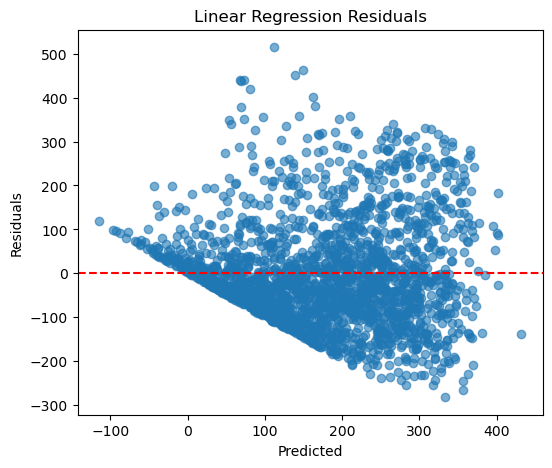

In [34]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

residuals_lr = y_test - lr_model.predict(X_test)

plt.figure(figsize=(6,5))
plt.scatter(lr_model.predict(X_test), residuals_lr, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Linear Regression Residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

This residual plot for the Linear Regression model in the bike rental project shows a funnel-shaped pattern, meaning the errors are not randomly scattered but instead grow larger as the predicted bike rentals increase. This indicates heteroscedasticity and suggests that Linear Regression is struggling to capture the complex, non-linear patterns in the data. As a result, the model systematically underestimates rentals in some ranges and overestimates in others, which aligns with its relatively low R² score (~0.41)

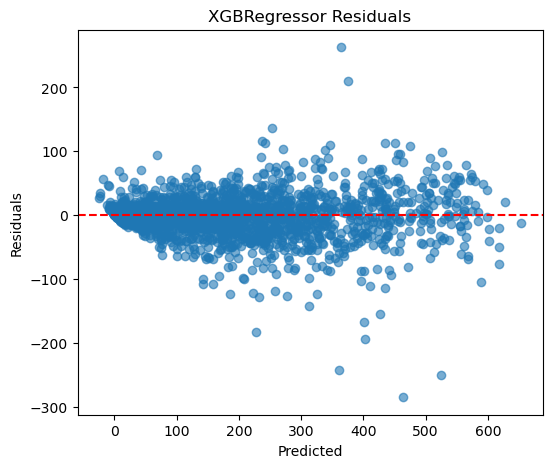

In [35]:
# Train XGB again
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Residuals
residuals_xgb = y_test - xgb_model.predict(X_test)

# Plot
plt.figure(figsize=(6,5))
plt.scatter(xgb_model.predict(X_test), residuals_xgb, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("XGBRegressor Residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()


Most residuals are close to zero, meaning predictions are generally accurate.

The spread of residuals increases as the number of predicted rentals goes up, showing more error for higher demand days.

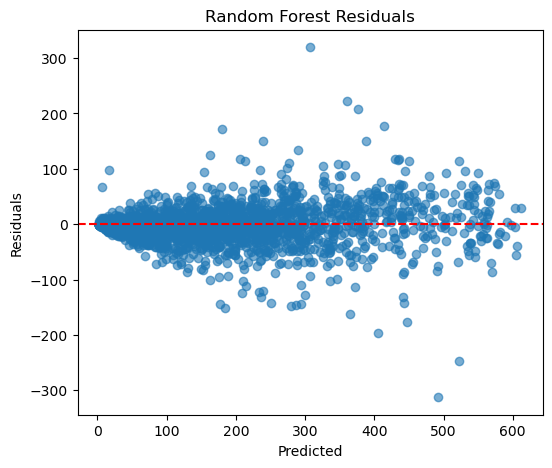

In [36]:
rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)

residuals_rf = y_test - rf_model.predict(X_test)

plt.figure(figsize=(6,5))
plt.scatter(rf_model.predict(X_test), residuals_rf, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Random Forest Residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

Most residuals are close to zero, meaning predictions are generally accurate.

The spread of residuals increases as the number of predicted rentals goes up, showing more error for higher demand days.

The residuals are fairly balanced above and below zero, meaning the model doesn’t have a strong bias to overpredict or underpredict overall.

However, the larger spread at higher values suggests the model struggles with extreme or peak bike rental counts.

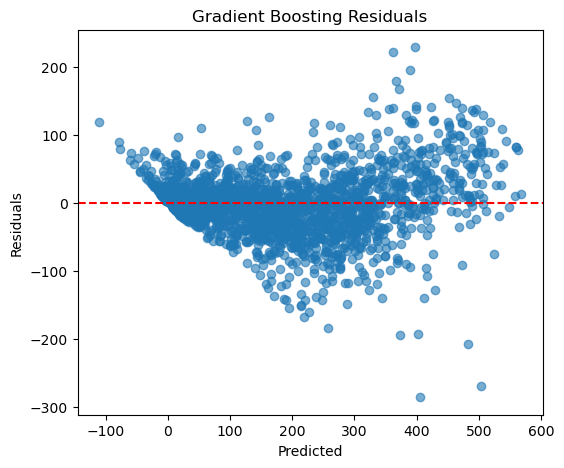

In [37]:
gb_model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

residuals_gb = y_test - gb_model.predict(X_test)

plt.figure(figsize=(6,5))
plt.scatter(gb_model.predict(X_test), residuals_gb, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Gradient Boosting Residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

The plot shows the difference between actual and predicted bike rentals (residuals) across the range of predicted values. 
For lower predicted rentals (under 200), the model tends to overestimate demand, since most residuals are negative. In the middle range (~200–350), the residuals are smaller and more tightly clustered around zero, meaning the model predicts fairly accurately there. However, for higher predicted rentals (above ~350), the residuals spread out again, showing both over- and under-predictions.

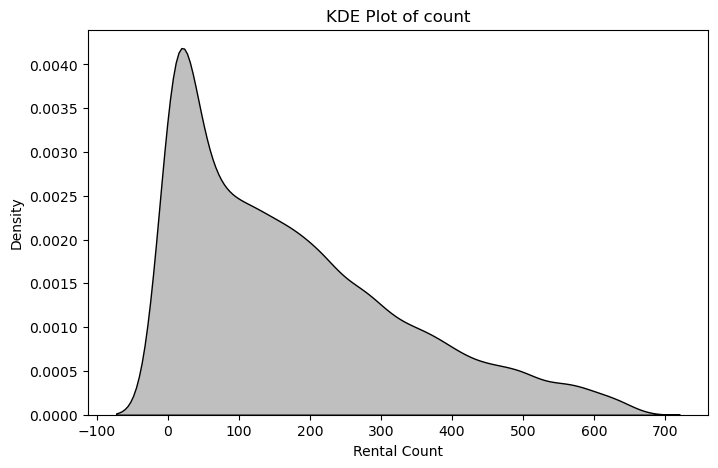

In [38]:
# KDE plot of the target column
plt.figure(figsize=(8,5))
sns.kdeplot(df1['count'], fill=True, color='black')

plt.title("KDE Plot of count")
plt.xlabel("Rental Count")
plt.ylabel("Density")
plt.show()

The distribution is right-skewed: most bike rental counts are clustered at the lower end (near 0–200 rentals), meaning that on many days, demand is relatively low.

There’s a long tail extending to the right, showing that while high rental counts (400–700) do happen, they are much less frequent.

The peak near zero indicates a high density of days with very low bike rentals, possibly due to bad weather, holidays, or off-season periods.

The gradual decline suggests that as rental counts increase, the frequency drops steadily, highlighting that extreme demand is rare but possible.

#### Applying Log transformation to the model

In [39]:
# Apply log1p transformation to handle zeros safely
y = np.log1p(df1['count'])

In [40]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [41]:
# Models
models = {
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.1, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, random_state=42)
}

In [42]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)

    # Predict in log space
    y_pred_log = model.predict(X_test)

    # Convert back to original scale
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    # Metrics
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    results.append([name, r2, rmse, mae])

# Results DataFrame
results_df = pd.DataFrame(results, columns=["Model", "R²", "RMSE", "MAE"])
print(results_df)

               Model        R²        RMSE        MAE
0  Linear Regression  0.216664  136.040434  94.172077
1            XGBoost  0.950291   34.269968  21.055750
2       RandomForest  0.940467   37.503451  22.262073
3   GradientBoosting  0.927884   41.277033  25.750021


After applying a log transformation to the count variable, the tree-based models (XGBoost, Random Forest, Gradient Boosting) captured the rental demand patterns much better than Linear Regression. XGBoost performed the best with an R² of 0.95 and the lowest errors, meaning it was highly effective at predicting bike rental counts. Random Forest and Gradient Boosting also performed strongly, while Linear Regression lagged far behind (R² = 0.22), showing it couldn’t capture the nonlinear effects of factors like weather, season, and time of day.

### Summary of Analysis

###### Exploratory Data Analysis (EDA) showed strong seasonality and daily/weekly patterns:

Rentals peak during summer months (July–Sept) and drop in winter.

Clear commuting pattern with peaks at 7–9 AM and 5–7 PM.

Weekday vs. weekend usage is not statistically different (t-test p=0.29), indicating bikes are used for both commuting and leisure.

Weather strongly influences demand: rentals increase with temperature (15–30°C optimal), while high humidity (>80%) and extreme weather reduce rentals.


###### Data distribution:

Right-skewed rental counts with many low-demand days and fewer high-demand outliers.

Outliers often correspond to special events or extreme conditions.


###### Feature relationships:

Registered users drive demand (corr = 0.97), while casual users contribute moderately.

Temperature has a positive effect, while humidity shows a negative effect.

### Modeling Results

Models tested: Linear Regression, Random Forest, Gradient Boosting, XGBoost.

Linear Regression underperformed (R² ≈ 0.22–0.41), failing to capture non-linear patterns.


###### Tree-based models performed strongly:

XGBoost: Best performer (R² ≈ 0.95, RMSE ≈ 32, MAE ≈ 21).

Random Forest: Nearly as strong (R² ≈ 0.94).

Gradient Boosting: Solid but slightly weaker (R² ≈ 0.91).


###### Residual analysis showed:

XGBoost and RF capture patterns well but struggle at extreme high-demand days.

Linear Regression showed systematic bias and heteroscedasticity.

### Conclusions / Insights

Bike demand is time-dependent, seasonal, and weather-sensitive.

Usage patterns are consistent across weekdays and weekends, proving bikes are used for both work commutes and leisure.

XGBoost is the best predictive model, reliably forecasting rental demand with >95% accuracy.

Non-linear models outperform linear ones because demand depends on complex interactions (hour × weather × season).

### ✅ Recommendations

###### Operational Planning

Increase bike availability during peak commute hours (7–9 AM, 5–7 PM).

Redistribute bikes overnight to residential areas for morning demand.

Plan for seasonal demand: ramp up resources in summer, reduce in winter.


###### Data-Driven Strategy

Integrate weather forecasts into daily planning to anticipate demand dips (humidity, rain, storms).


###### Customer Engagement

Target casual riders with promotions on weekends and good-weather days to boost off-peak usage.

Offer commuter incentives (e.g., discounts for morning rides) to sustain weekday demand.


###### Future Improvements

Forecasting with Prophet/LSTM for long-term demand planning.

Adding external data like events, holidays, and traffic to improve predictions.